In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return beta * torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 30

beta = 0.09

kl_weight = 128/len(trainset)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + beta * kl_weight * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.25it/s]


Epoch: 0 - TrainRecLoss: 221.9010947091239 - ValidRecLoss: 192.86567089225673
Epoch: 0 - TrainDivLoss: 4.707075415055519 - ValidDivLoss: 6.4931244699260855


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.50it/s]


Epoch: 1 - TrainRecLoss: 190.7670378532491 - ValidRecLoss: 188.4655188065541
Epoch: 1 - TrainDivLoss: 5.779135178401272 - ValidDivLoss: 5.474510198907007


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.49it/s]


Epoch: 2 - TrainRecLoss: 188.1590399182936 - ValidRecLoss: 187.05271428748023
Epoch: 2 - TrainDivLoss: 5.0523940906850004 - ValidDivLoss: 4.734097625635847


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 158.25it/s]


Epoch: 3 - TrainRecLoss: 186.89369484712321 - ValidRecLoss: 185.92912022071548
Epoch: 3 - TrainDivLoss: 4.499524693499242 - ValidDivLoss: 4.541974900644036


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 153.61it/s]


Epoch: 4 - TrainRecLoss: 185.91795804607335 - ValidRecLoss: 184.7104484461531
Epoch: 4 - TrainDivLoss: 4.045869585293443 - ValidDivLoss: 3.8890831530848637


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 151.51it/s]


Epoch: 5 - TrainRecLoss: 184.63333289302997 - ValidRecLoss: 183.42357703100276
Epoch: 5 - TrainDivLoss: 3.807181850425216 - ValidDivLoss: 3.6408050090451782


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 145.51it/s]


Epoch: 6 - TrainRecLoss: 183.10072967594365 - ValidRecLoss: 181.8530037795441
Epoch: 6 - TrainDivLoss: 3.7244628833046853 - ValidDivLoss: 3.667447735991659


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.43it/s]


Epoch: 7 - TrainRecLoss: 181.45197932196578 - ValidRecLoss: 180.18562201004994
Epoch: 7 - TrainDivLoss: 3.751356239257845 - ValidDivLoss: 3.727254629135132


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 149.82it/s]


Epoch: 8 - TrainRecLoss: 180.08219258973338 - ValidRecLoss: 178.69922995265526
Epoch: 8 - TrainDivLoss: 3.776150154914937 - ValidDivLoss: 3.820508793939518


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 155.38it/s]


Epoch: 9 - TrainRecLoss: 178.87892297285197 - ValidRecLoss: 177.40512818928008
Epoch: 9 - TrainDivLoss: 3.776200577648464 - ValidDivLoss: 3.7019873510433148


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 147.33it/s]


Epoch: 10 - TrainRecLoss: 177.90171254367462 - ValidRecLoss: 176.47543412220628
Epoch: 10 - TrainDivLoss: 3.723265513682416 - ValidDivLoss: 3.6172050916695895


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 161.32it/s]


Epoch: 11 - TrainRecLoss: 177.108119647386 - ValidRecLoss: 175.6031256567074
Epoch: 11 - TrainDivLoss: 3.6719249636887996 - ValidDivLoss: 3.5595537167561204


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.56it/s]


Epoch: 12 - TrainRecLoss: 176.36920566192822 - ValidRecLoss: 175.06644835653185
Epoch: 12 - TrainDivLoss: 3.639576621655462 - ValidDivLoss: 3.5807436417929734


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 156.17it/s]


Epoch: 13 - TrainRecLoss: 175.67506213483017 - ValidRecLoss: 174.37014673933197
Epoch: 13 - TrainDivLoss: 3.6577079499454133 - ValidDivLoss: 3.661419681355923


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 154.21it/s]


Epoch: 14 - TrainRecLoss: 174.99763749047383 - ValidRecLoss: 173.83085207395916
Epoch: 14 - TrainDivLoss: 3.67230909211295 - ValidDivLoss: 3.774204616305194


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.00it/s]


Epoch: 15 - TrainRecLoss: 174.30646337578293 - ValidRecLoss: 173.05234170261818
Epoch: 15 - TrainDivLoss: 3.7465528704718487 - ValidDivLoss: 3.6683977042572407


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 149.98it/s]


Epoch: 16 - TrainRecLoss: 173.74959673200334 - ValidRecLoss: 172.47992967050286
Epoch: 16 - TrainDivLoss: 3.7747470020993688 - ValidDivLoss: 3.8098969338815425


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.20it/s]


Epoch: 17 - TrainRecLoss: 173.1898811519273 - ValidRecLoss: 173.0362143214745
Epoch: 17 - TrainDivLoss: 3.831132354512652 - ValidDivLoss: 3.985978102382225


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 155.10it/s]


Epoch: 18 - TrainRecLoss: 172.70282216671941 - ValidRecLoss: 171.95798250995105
Epoch: 18 - TrainDivLoss: 3.8767097540247413 - ValidDivLoss: 3.789003200168851


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 155.08it/s]


Epoch: 19 - TrainRecLoss: 172.30073622193163 - ValidRecLoss: 171.39588329460048
Epoch: 19 - TrainDivLoss: 3.903551767629855 - ValidDivLoss: 3.889104945750176


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 154.45it/s]


Epoch: 20 - TrainRecLoss: 171.9376978437021 - ValidRecLoss: 171.735799282412
Epoch: 20 - TrainDivLoss: 3.93526558327014 - ValidDivLoss: 3.794040136699435


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.55it/s]


Epoch: 21 - TrainRecLoss: 171.59305710782374 - ValidRecLoss: 170.7731468104109
Epoch: 21 - TrainDivLoss: 3.987905157146169 - ValidDivLoss: 3.965713793718362


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 145.50it/s]


Epoch: 22 - TrainRecLoss: 171.2873577451401 - ValidRecLoss: 170.63393913945066
Epoch: 22 - TrainDivLoss: 4.004133166534814 - ValidDivLoss: 3.971404552459717


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 156.10it/s]


Epoch: 23 - TrainRecLoss: 171.03552883774486 - ValidRecLoss: 170.27768678303008
Epoch: 23 - TrainDivLoss: 4.031523164147253 - ValidDivLoss: 3.991709911370579


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 154.61it/s]


Epoch: 24 - TrainRecLoss: 170.78798738979836 - ValidRecLoss: 170.15510250043266
Epoch: 24 - TrainDivLoss: 4.084938169288229 - ValidDivLoss: 4.08588330956954


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.78it/s]


Epoch: 25 - TrainRecLoss: 170.59960185947702 - ValidRecLoss: 170.3207455405706
Epoch: 25 - TrainDivLoss: 4.100977330319663 - ValidDivLoss: 4.030122301246546


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.66it/s]


Epoch: 26 - TrainRecLoss: 170.22629233158983 - ValidRecLoss: 169.67627069014537
Epoch: 26 - TrainDivLoss: 4.150040633134497 - ValidDivLoss: 4.334112565728683


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 160.18it/s]


Epoch: 27 - TrainRecLoss: 170.09599453858985 - ValidRecLoss: 169.2586480635631
Epoch: 27 - TrainDivLoss: 4.2306927272251675 - ValidDivLoss: 4.215892550311511


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.26it/s]


Epoch: 28 - TrainRecLoss: 169.84429157314017 - ValidRecLoss: 169.17952042591722
Epoch: 28 - TrainDivLoss: 4.2934016835714965 - ValidDivLoss: 4.252244427234312


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 155.19it/s]

Epoch: 29 - TrainRecLoss: 169.69638562558302 - ValidRecLoss: 169.0846318112144
Epoch: 29 - TrainDivLoss: 4.324711646606673 - ValidDivLoss: 4.290753132180322


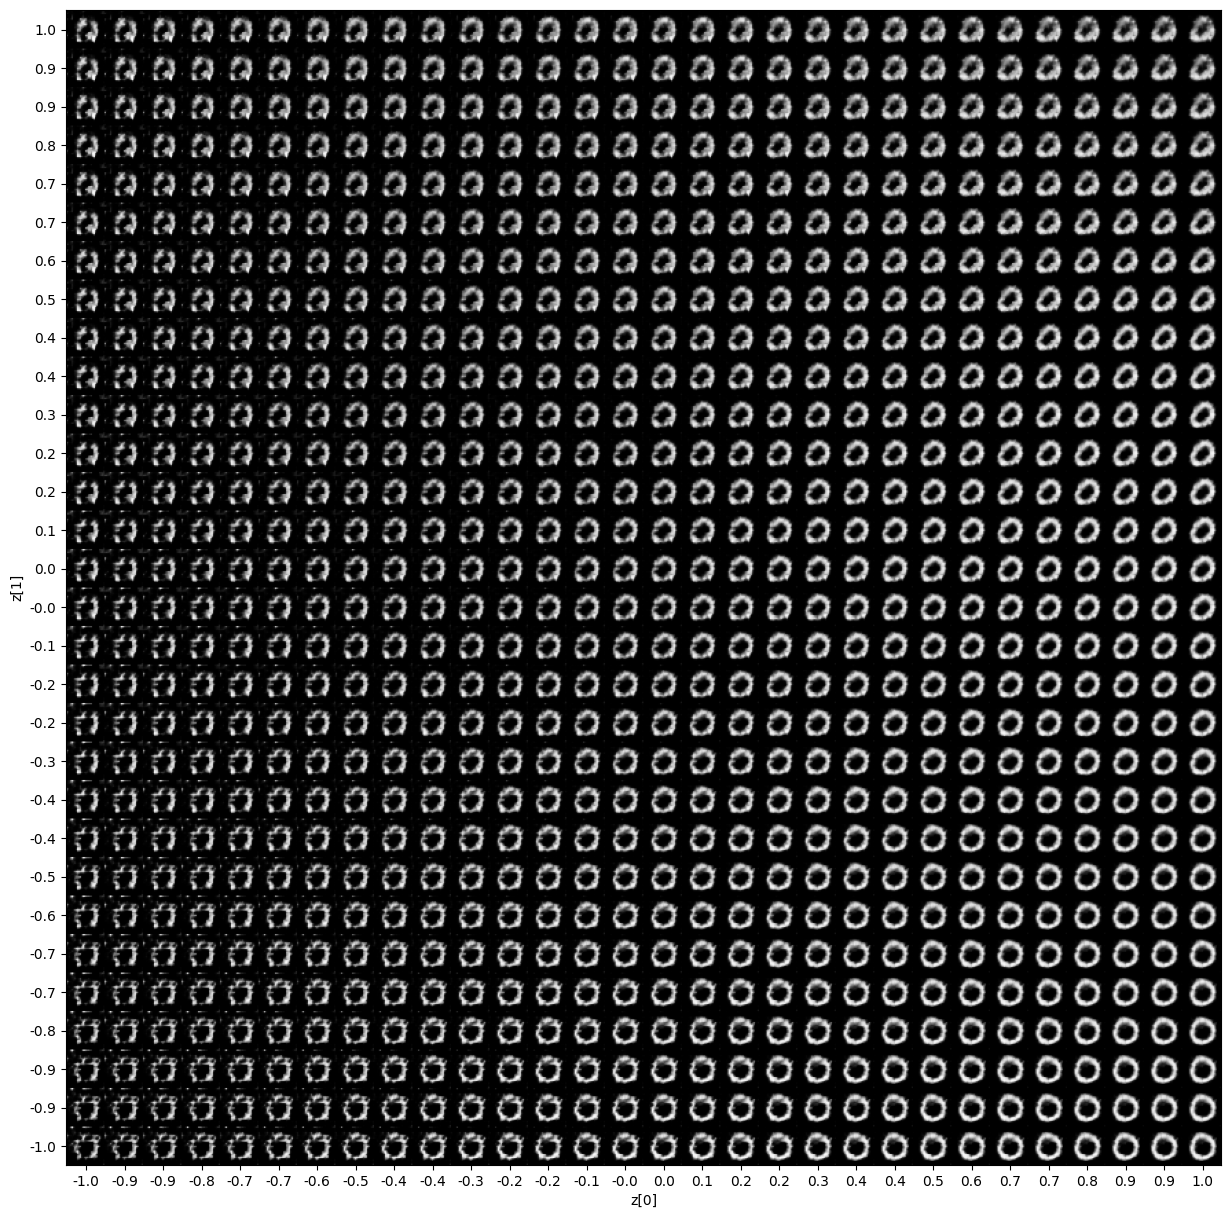

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()